In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.get_npr_data()
df.head()

The df has 1889857 rows and 12 columns.


,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [3]:
df = df.sample(20_000)

In [4]:
# df['utterance_length'] = len(df.utterance.split())
df['utterance_word_count'] = df.utterance.apply(str.split).apply(len)
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count
1339716,32583,22,mr. mohammed naseehu ali,Attacks. Mm-hmm.,news & notes,what's in a (muslim) name?,False,attacks. mm hmm .,attacks. mm hmm .,-0.4404,2007-09-11,2
1804276,71897,203,neal conan,We have a lot of e-mails that we have to read ...,talk of the nation,a look back at the top stories of 2007,True,we have a lot of e mails that we have to read ...,we have a lot of e mail that we have to read t...,0.7003,2007-12-31,81
321541,76420,28,eyder peralta byline,"He points at Fouez, his 16-year-old.",morning edition,trump travel ban forces somalis to remain at k...,False,"he points at fouez , his 16 year old .","he point at fouez , his 16 year old .",0.0000,2017-02-03,6
3119248,119700,7,mr. mustafa shabib aljabour,(Through translator) Those are our sons and mi...,morning edition,"u.s. offers training, pay as it frees iraqi de...",False,through translator those are our sons and mist...,through translator those are our son and mista...,-0.6697,2008-05-16,20
2362958,69632,59,mr. rami khouri,"Today, though, you have Iraq, you have Iran, y...",talk of the nation,"the 2008 election, as seen from overseas",False,"today , though , you have iraq , you have iran...","today , though , you have iraq , you have iran...",-0.2228,2008-06-05,121


#### A quick lesson on .apply:

In [5]:
df['question_mark_count'] = df.utterance.str.count(r"[\?]")
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count,question_mark_count
1339716,32583,22,mr. mohammed naseehu ali,Attacks. Mm-hmm.,news & notes,what's in a (muslim) name?,False,attacks. mm hmm .,attacks. mm hmm .,-0.4404,2007-09-11,2,0
1804276,71897,203,neal conan,We have a lot of e-mails that we have to read ...,talk of the nation,a look back at the top stories of 2007,True,we have a lot of e mails that we have to read ...,we have a lot of e mail that we have to read t...,0.7003,2007-12-31,81,0
321541,76420,28,eyder peralta byline,"He points at Fouez, his 16-year-old.",morning edition,trump travel ban forces somalis to remain at k...,False,"he points at fouez , his 16 year old .","he point at fouez , his 16 year old .",0.0000,2017-02-03,6,0
3119248,119700,7,mr. mustafa shabib aljabour,(Through translator) Those are our sons and mi...,morning edition,"u.s. offers training, pay as it frees iraqi de...",False,through translator those are our sons and mist...,through translator those are our son and mista...,-0.6697,2008-05-16,20,0
2362958,69632,59,mr. rami khouri,"Today, though, you have Iraq, you have Iran, y...",talk of the nation,"the 2008 election, as seen from overseas",False,"today , though , you have iraq , you have iran...","today , though , you have iraq , you have iran...",-0.2228,2008-06-05,121,0


## Who asks the most questions?

In [6]:
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,speaker,count
5851,neal conan,2633
2191,ira flatow,738
7019,steve inskeep,583
6597,robert siegel,547
3352,melissa block,427
6437,renee montagne,387
1837,farai chideya,383
6777,scott simon,372
6371,rachel martin,359
1077,david greene,322


In [7]:
questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [8]:
questions = questions.merge(df, how='left', on='speaker').drop(columns=['story_id_num', 'utterance_order', 'utterance',
       'title','clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'])
questions

,speaker,count,program,is_host,date
0,neal conan,2633,talk of the nation,True,2007-12-31
1,neal conan,2633,talk of the nation,True,2007-12-05
2,neal conan,2633,talk of the nation,True,2009-12-17
3,neal conan,2633,talk of the nation,True,2005-06-16
4,neal conan,2633,talk of the nation,True,2012-02-15
...,...,...,...,...,...
19995,khalid,1,talk of the nation,False,2011-03-08
19996,khaled nabawy,1,weekend edition saturday,False,2014-04-05
19997,keyes,1,news & notes,False,2005-05-19
19998,kevin phillips,1,morning edition,False,2006-04-17


In [9]:
df=df.set_index('date').sort_index()

In [10]:
host_df = df[df.is_host==True]

In [11]:
guest_df = df[df.is_host!=True]

In [12]:
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

- This is a list of the 12 hosts with the most observations

In [13]:
# hosts_with_the_most

In [14]:
top_hosts_df = df[df.speaker.isin(hosts_with_the_most)]


In [15]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,69,neal conan,Yeah.,talk of the nation,difference between a think and a 'blink',True,yeah .,yeah .,0.296,1,0


In [16]:
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,69,neal conan,Yeah.,talk of the nation,difference between a think and a 'blink',True,yeah .,yeah .,0.2960,1,0
2005-01-26,84356,61,john,OK. Thank you. Bye.,talk of the nation,spy and tell: ex-cia agents write what they know,False,ok. thank you. bye .,ok. thank you. bye .,0.5719,4,0
2005-01-26,84356,43,ms. lindsay moran,"Well, I actually take that as a compliment, to...",talk of the nation,spy and tell: ex-cia agents write what they know,False,"well , i actually take that as a compliment , ...","well , i actually take that a a compliment , t...",0.9117,70,0
2005-01-26,84356,176,neal conan,That's a great book.,talk of the nation,spy and tell: ex-cia agents write what they know,True,that s a great book .,that s a great book .,0.6249,4,0
2005-01-26,84356,12,neal conan,"I think one of the lines you said, `At the end...",talk of the nation,spy and tell: ex-cia agents write what they know,True,"i think one of the lines you said , at the end...","i think one of the line you said , at the end ...",0.0000,28,0


In [17]:
cluster_df= df[['vader','utterance_word_count','question_mark_count']]

array([[<AxesSubplot:title={'center':'vader'}>,
        <AxesSubplot:title={'center':'utterance_word_count'}>],
       [<AxesSubplot:title={'center':'question_mark_count'}>,
        <AxesSubplot:>]], dtype=object)

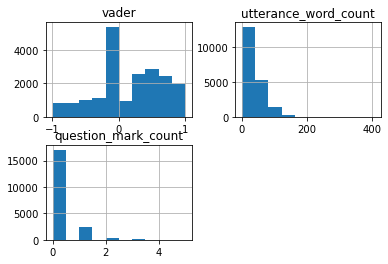

In [18]:
cluster_df.hist()

In [19]:
# cluster_df[
df[df.utterance_word_count == df.utterance_word_count.max()]

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2014-07-24,98765,2,jason sheehan byline,"I've caught myself pushing ""Tigerman"" on frien...",all things considered,'tigerman' will get its claws into you,False,i ve caught myself pushing tigerman on friends...,i ve caught myself pushing tigerman on friends...,0.9684,407,0


In [20]:
# Scale the cluster_df

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(cluster_df)
cluster_df_scaled = pd.DataFrame(scaler.transform(cluster_df), columns= cluster_df.columns).set_index([cluster_df.index.values])


In [21]:
cluster_df_scaled.head()

,vader,utterance_word_count,question_mark_count
2005-01-11,0.253263,-1.091121,-0.377777
2005-01-26,0.834395,-0.997037,-0.377777
2005-01-26,1.550120,1.072816,-0.377777
2005-01-26,0.946030,-0.997037,-0.377777
2005-01-26,-0.370205,-0.244363,-0.377777


In [22]:
from sklearn.cluster import KMeans

In [27]:
# sklearn implementation of KMeans

#define the thing
kmeans_cluster_df_scaled = KMeans(n_clusters=2, random_state = 123, verbose = 0)

# fit the thing
kmeans_cluster_df_scaled.fit(cluster_df_scaled)

# Use (predict using) the thing 
kmeans_cluster_df_scaled.predict(cluster_df_scaled)

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [28]:
import matplotlib.pyplot as plt
import re, seaborn as sns
import numpy as np
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [29]:
cluster_df_scaled.columns

Index(['vader', 'utterance_word_count', 'question_mark_count'], dtype='object')

<IPython.core.display.Javascript object>


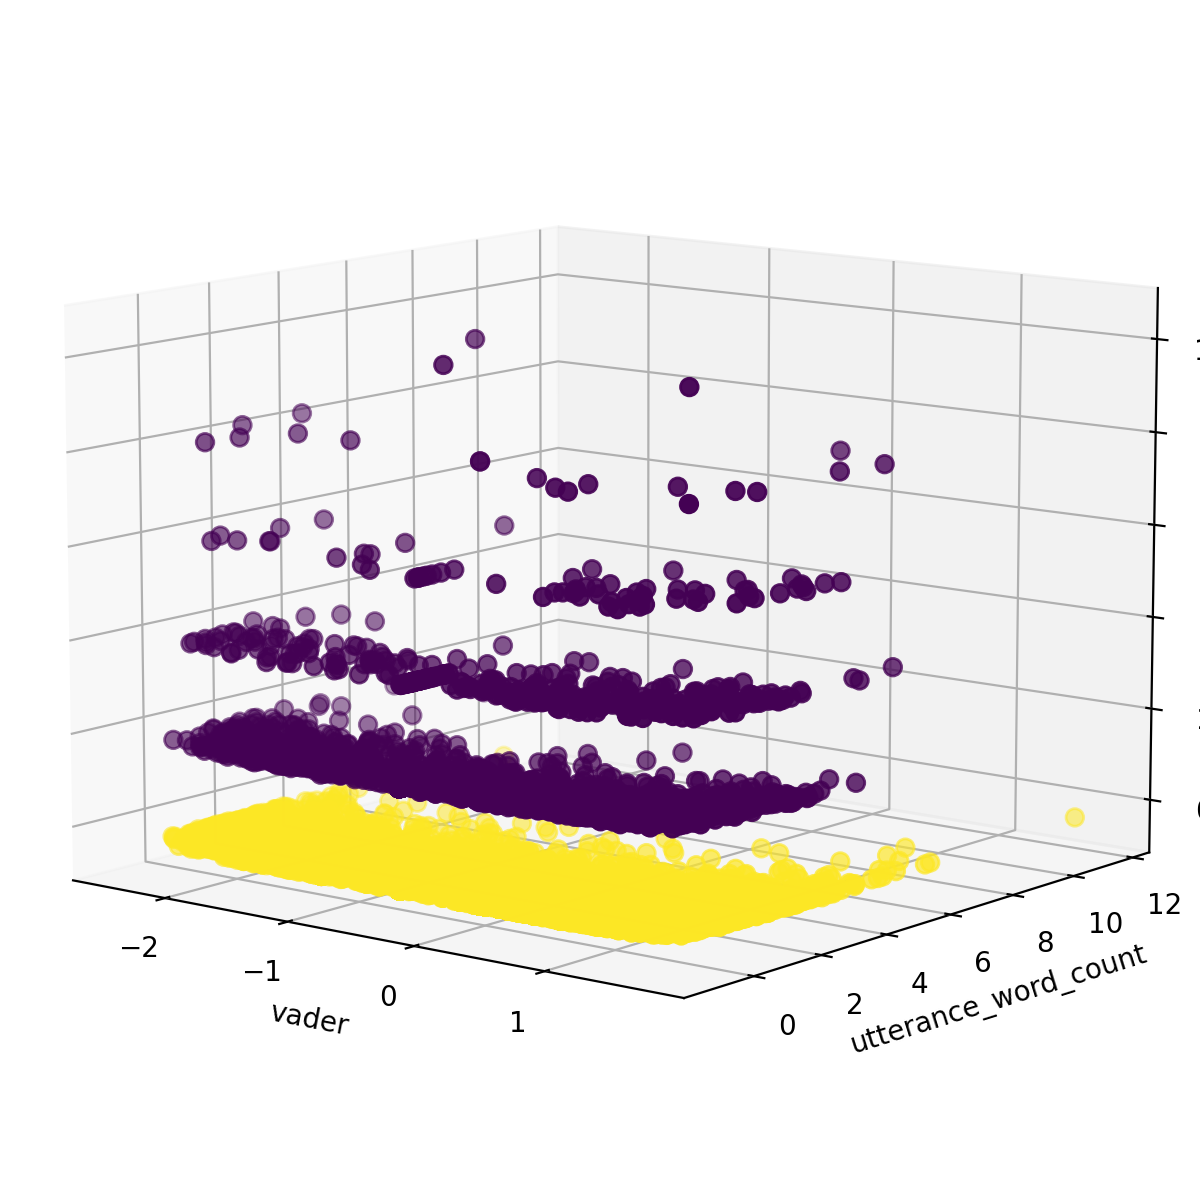

In [30]:
# The following command will make the graphic interactive
# but it creates problems for subsequent graphics and should be commented out 
# until it's being used

%matplotlib notebook



# assigning the graphing data
x = cluster_df_scaled.vader
y = cluster_df_scaled.utterance_word_count
z = cluster_df_scaled.question_mark_count
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
t = kmeans_cluster_df_scaled.predict(cluster_df_scaled)
# plot
# the x,y,z labels might need to be specific...
sc = ax.scatter(x, y, z, s=40, c=t, marker='o')#, cmap=t, alpha=1)
ax.set_xlabel('vader')
ax.set_ylabel('utterance_word_count')
ax.set_zlabel('question_mark_count')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')